# Video Face Manipulation Detection Through Ensemble of CNNs
Image and Sound Processing Lab - Politecnico di Milano
- Nicolò Bonettini
- Edoardo Daniele Cannas
- Sara Mandelli
- Luca Bondi
- Paolo Bestagini

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/polimi-ispl/icpr2020dfdc
!pip install efficientnet-pytorch
!pip install -U git+https://github.com/albu/albumentations > /dev/null
#%cd icpr2020dfdc/notebook

Cloning into 'icpr2020dfdc'...
remote: Enumerating objects: 645, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 645 (delta 96), reused 80 (delta 80), pack-reused 537
Receiving objects: 100% (645/645), 99.63 MiB | 40.36 MiB/s, done.
Resolving deltas: 100% (336/336), done.
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=49507e5bb1420b0ce2f8465dcc7791042d9a862ee5e493e2bb9b765bfd258139
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-tzozavxl


In [3]:
import os

os.mkdir('/content/icpr2020dfdc/faces_dfdc')
os.mkdir('/content/icpr2020dfdc/checkpoint_dfdc')
os.mkdir('/content/icpr2020dfdc/data')
os.mkdir('/content/icpr2020dfdc/df_faces_dfdc')


os.mkdir('/content/icpr2020dfdc/weights')
os.mkdir('/content/icpr2020dfdc/weights/binclass')


In [4]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/DEEP_FAKE_DETECTION_2023/FINAL________DFDC/faces_dfdc.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/icpr2020dfdc/faces_dfdc')

In [5]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/DEEP_FAKE_DETECTION_2023/FINAL________DFDC/data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/icpr2020dfdc/data')

In [6]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/DEEP_FAKE_DETECTION_2023/FINAL________DFDC/checkpoint_dfdc.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/icpr2020dfdc/checkpoint_dfdc')

In [7]:
# importing required packages
from pathlib import Path
import shutil
import os

# defining source and destination
# paths
src = '/content/drive/MyDrive/DEEP_FAKE_DETECTION_2023/FINAL________DFDC/df_faces_dfdc'
trg = '/content/icpr2020dfdc/df_faces_dfdc'
shutil.copy2(src, trg)

'/content/icpr2020dfdc/df_faces_dfdc/df_faces_dfdc'

In [13]:
import os
os.mkdir('/content/icpr2020dfdc/weights/binclass/net-EfficientNetAutoAttB4_traindb-dfdc-35-5-10_face-scale_size-224_seed-41')

In [14]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/DEEP_FAKE_DETECTION_2023/PRETRAINED_MODELS/EfficientNetAutoAttB4_DFDC.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/icpr2020dfdc/weights/binclass/net-EfficientNetAutoAttB4_traindb-dfdc-35-5-10_face-scale_size-224_seed-41')

In [8]:
cd /content/icpr2020dfdc

/content/icpr2020dfdc


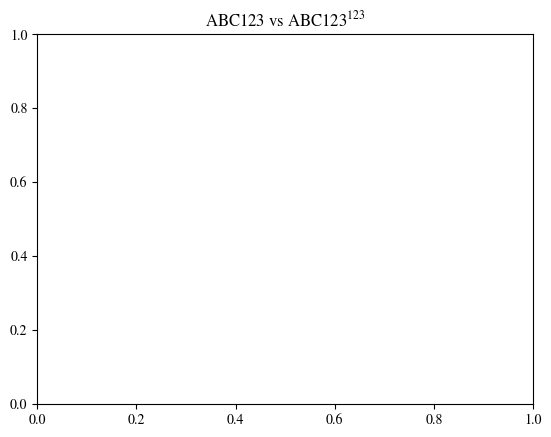

In [9]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import sklearn.manifold
import numpy as np
import torch
from torchvision.transforms import ToPILImage
from PIL import Image,ImageChops
from tqdm.notebook import tqdm

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')

import sys
sys.path.append('..')

from isplutils import split, data, utils
from architectures import fornet

In [18]:
splits = split.make_splits(dbs={'test':['ff-c23-720-140-140','dfdc-35-5-10']})

TypeError: ignored

In [16]:
df_all = pd.concat(dfs,ignore_index=True)
df_all

NameError: ignored

In [17]:
df = splits['test']['dfdc-35-5-10'][0]
root = Path(splits['test']['dfdc-35-5-10'][1])


NameError: ignored

In [21]:
model_path = 'weights/binclass/net-EfficientNetAutoAttB4_traindb-dfdc-35-5-10_face-scale_size-224_seed-41/bestval.pth'
net = fornet.EfficientNetAutoAttB4ST().eval()
net.load_state_dict(torch.load(model_path,map_location='cpu')['net'])

Loaded pretrained weights for efficientnet-b4


RuntimeError: ignored

In [22]:
face_size = 224
face_policy='scale'
transformer = utils.get_transformer(face_policy=face_policy, patch_size=face_size,
                                    net_normalizer=net.get_normalizer(), train=False)

# Attention masks

In [23]:
%matplotlib notebook

fig_im,axis_im = plt.subplots(3,3,figsize=(5,5))
fig_att,axis_att = plt.subplots(3,3,figsize=(5,5))
axis_im = axis_im.reshape(-1)
axis_att = axis_att.reshape(-1)

np.random.seed(41)
records = df.loc[np.random.choice(df.index,len(axis_im),replace=False)]

for idx,(ax_im,ax_att) in enumerate(zip(axis_im,axis_att)):
    record = records.iloc[idx]
    frame_im = Image.open(root.joinpath(record.name))
    bb = record['left'], record['top'], record['right'], record['bottom']
    face_im = utils.extract_bb(frame_im, bb=bb, size=face_size, scale=face_policy)
    face_t = data.load_face(record=record,
                          root=root,
                          size=face_size,
                          scale=face_policy,
                          transformer=transformer)
    with torch.no_grad():
        if hasattr(net,'feat_ext'):
            att = net.feat_ext.get_attention(face_t.unsqueeze(0))[0].cpu()
        else:
            att = net.get_attention(face_t.unsqueeze(0))[0].cpu()
    att_img = ToPILImage()(att)
    att_img = att_img.resize(face_im.size, resample=Image.NEAREST).convert('RGB')
    face_att_img = ImageChops.multiply(face_im, att_img)
    ax_im.imshow(face_im)
    ax_im.set_xticks([])
    ax_im.set_yticks([])
    ax_att.imshow(face_att_img)
    ax_att.set_xticks([])
    ax_att.set_yticks([])

fig_im.tight_layout()
fig_att.tight_layout()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NameError: ignored

# Feature vectors

In [ ]:
num_videos = 20

np.random.seed(41)
real_videos = np.random.choice(df[df['label']==False]['video'].unique(),num_videos//2,replace=False)
fake_videos = np.random.choice(df[df['label']==True]['video'].unique(),num_videos//2,replace=False)
videos = np.concatenate((real_videos,fake_videos))

records = df.loc[df['video'].isin(videos)]

feat_list = []
for _,record in tqdm(records.iterrows(),total=len(records)):
    face_t = data.load_face(record=record,
                          root=root,
                          size=face_size,
                          scale=face_policy,
                          transformer=transformer)
    with torch.no_grad():
        feat = net.features(face_t.unsqueeze(0))
    feat_list.append(feat)

In [ ]:
tsne = sklearn.manifold.TSNE(n_components=2,random_state=43)
tsne_feat = tsne.fit_transform(np.concatenate(feat_list))

<IPython.core.display.Javascript object>


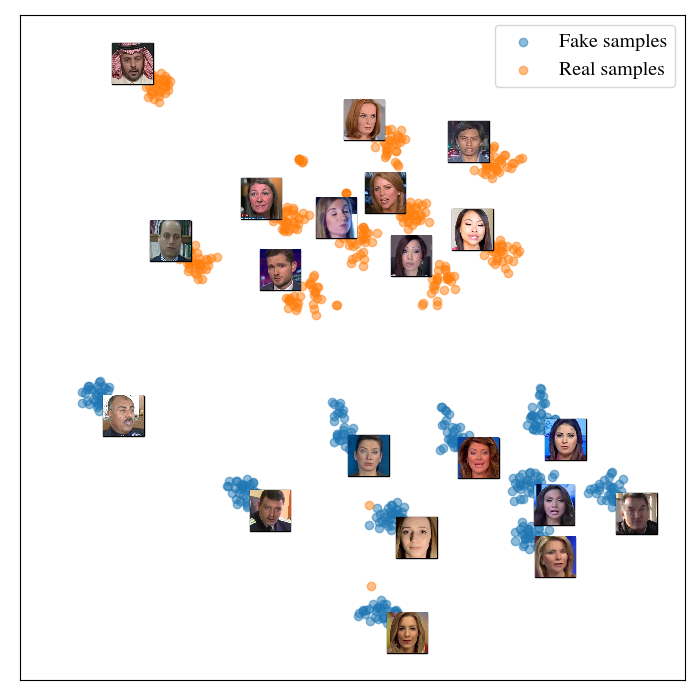

In [ ]:
%matplotlib notebook

fig,ax = plt.subplots(1,1,figsize=(7,7))

for video in videos:
    record = records.loc[records['video'] == video].iloc[0]
    frame_im = Image.open(root.joinpath(record.name))
    bb = record['left'], record['top'], record['right'], record['bottom']
    face_im = utils.extract_bb(frame_im, bb=bb, size=face_size, scale=face_policy)

    img_ctr = np.median(tsne_feat[records['video'] == video],axis=0)

    imagebox = offsetbox.AnnotationBbox(
        offsetbox.OffsetImage(
            face_im,zoom=0.13,resample=True
        ),
        xy=img_ctr+((-3,3) if not record['label'] else (3,-3)),
        pad=0
    )
    ax.add_artist(imagebox)

ax.scatter(tsne_feat[records['label']==True,0],tsne_feat[records['label']==True,1],label='Fake samples',alpha=0.5)
ax.scatter(tsne_feat[records['label']==False,0],tsne_feat[records['label']==False,1],label='Real samples',alpha=0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(ax.get_ylim()[0]-4,ax.get_ylim()[1]+4)
ax.set_xlim(ax.get_xlim()[0]-4,ax.get_xlim()[1]+4)

ax.legend(fontsize='x-large')
fig.tight_layout()
fig.savefig('tsne_projection.pdf')